### Model initialisation

In [1]:
from models import *
from datasets import *
from utils import *
from torch import nn
from escnn import nn as enn
import numpy as np
import os
import torch
from torchvision.transforms import InterpolationMode, Resize

with torch.no_grad():
    torch.cuda.empty_cache()

def train_loop(dataloader, model, loss_fn, optimizer):
    model.train() # Sets the model to training mode -- important for batch normalization and dropout layers
    train_loss = 0.0
    for (x, y) in dataloader:
        # Compute prediction and loss
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = loss_fn(pred, y)
        train_loss += loss.item() * len(x)
    
        # Backpropagation
        optimizer.zero_grad() # Resets gradient
        loss.backward() # Backpropagates the prediction loss
        optimizer.step() # Adjusts the parameters by the gradients collected in the backward pass
    return train_loss / len(dataloader.dataset)

def valid_loop(dataloader, model, loss_fn):
    model.eval() # Sets the model to evaluation mode -- important for batch normalization and dropout layers
    valid_loss = 0.0
    with torch.no_grad(): # Ensures that no gradients are computed during test mode
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            valid_loss += loss_fn(pred, y).item() * len(x)
    return valid_loss / len(dataloader.dataset)

def set_seeds(seed: int = 42) -> None:
    """
    Do not forget to run `torch.use_deterministic_algorithms(True)`
    just after importing torch in your main program.
    """
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

    # torch.use_deterministic_algorithms(True)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 42
set_seeds(seed)

2024-05-08 14:37:59.550883: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-08 14:38:00.318777: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Model and hyperparameter selection

In [2]:
model_dir = '/home/hubble/data/trained_models'
data_dir = "/home/hubble/data/decaying_turbulence/velocity"

device = get_device()

# Model
model_name = "DSCMS_C8"
postfix = "_DA" # For loading/saving models and tensor board data
model = create_model(model_name).to(device)
start_epoch = 750 # Will load existing model if start_epoch is greater than 0.

# Training parameters
learning_rate = 1.0e-03
epochs = 100
batch_size = 64
earlystops = [20]

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Data selection
samples = 7000
resolution = 16
interpolation = "nearest"
data_augmentation_group = "D4"
num_workers = 2
dataloaders = create_dataloaders(data_dir, batch_size, resolution, num_workers, interpolation, samples, data_augmentation_group)

# Load model
if start_epoch > 0:
    file_name = f"{model_name}{postfix}_bs{batch_size}_d{samples}_r{resolution}_e{start_epoch}.tar"
    file_path = os.path.join(model_dir, file_name)
    assert os.path.exists(file_path), f"Did not find a saved model with the name '{file_name}'."
    checkpoint = torch.load(file_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    early_stop_count = checkpoint['early_stop_count']
    model.eval()
    print(f"Loaded state at epoch {start_epoch} with an early stop count of {early_stop_count}.")

# Scheduler
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10], gamma=0.1, last_epoch=start_epoch-1)
enableScheduler = False

Using cuda device.
norm
norm
norm
Loaded DSCMS_C4 with 32276 trainable parameters.


AssertionError: Did not find a saved model with the name 'DSCMS_C4_DA_bs64_d7000_r16_e750.tar'.

### Model training

 94%|█████████████████████████████████████▌  | 94/100 [2:20:47<08:59, 89.87s/it]

Ran out of patience at epoch 744. Best epoch is 725 with a loss of 0.0723431805173556.
No more patience left.


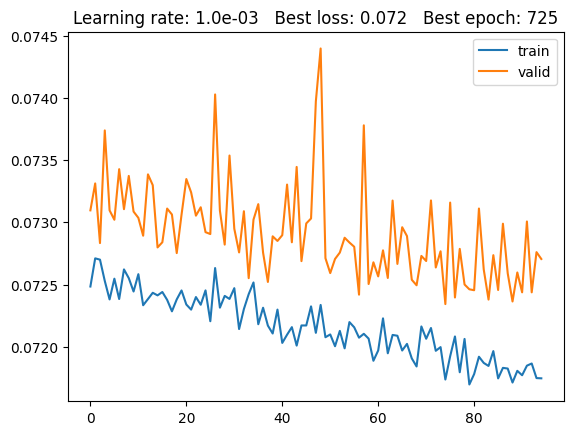

In [3]:
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(f"runs/{model_name}{postfix}_bs{batch_size}_d{samples}_r{resolution}")

output_file = os.path.join(model_dir, model_name)

best_loss = np.inf
best_epoch = -1
train_loss_values = list()
valid_loss_values = list()
patience = earlystops.pop(0)
for epoch in tqdm(range(start_epoch, start_epoch+epochs)):
    train_loss = train_loop(dataloaders["train"], model, loss_fn, optimizer)
    valid_loss = valid_loop(dataloaders["valid"], model, loss_fn)
    if enableScheduler:
        scheduler.step()
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/valid', valid_loss, epoch)
    train_loss_values.append(train_loss)
    valid_loss_values.append(valid_loss)
    if valid_loss < best_loss:
        early_stop_count = 0
        best_loss = valid_loss
        best_epoch = epoch+1
        best_weights = deepcopy(model.state_dict())
        best_optim = optimizer.state_dict()
    else:
        early_stop_count += 1
    if early_stop_count >= patience:
        print(f"Ran out of patience at epoch {epoch}. Best epoch is {best_epoch} with a loss of {best_loss}.")
        save_checkpoint(f"{output_file}{postfix}_bs{batch_size}_d{samples}_r{resolution}_e{best_epoch}.tar", best_weights, best_optim, early_stop_count)
        torch.save(best_weights, f"{output_file}{postfix}_bs{batch_size}_d{samples}_r{resolution}.pt")
        if earlystops:
            patience = earlystops.pop(0)
            print(f"Saving the model and resuming with a patience of {patience}.")
        else:
            print(f"No more patience left.")
            break
        
writer.flush()
writer.close()
if epoch == start_epoch+epochs-1:
    last_weights = deepcopy(model.state_dict())
    last_optim = optimizer.state_dict()
    save_checkpoint(f"{output_file}{postfix}_bs{batch_size}_d{samples}_r{resolution}_e{start_epoch+epochs}.tar", last_weights, last_optim, early_stop_count)
    print(f"Reached the last epoch without losing patience. early_stop_count={early_stop_count}")
plt.plot(train_loss_values, label="train")
plt.plot(valid_loss_values, label="valid")
plt.title(f"Learning rate: {learning_rate:>.1e}   Best loss: {best_loss:>.3f}   Best epoch: {best_epoch}")
plt.legend()
plt.show()

# DSCMS     1.0e-4, 20 Patience: 35.60 s/it, best epoch 574
# DSCMS_C4  1.0e-3, 20 Patience: 52.82 s/it, best epoch 474
# DSCMS_C8  1.0e-3, 20 Patience: 84.75 s/it, best epoch 
# DSCMS_D4  1.0e-3, 20 Patience: 86.37 s/it, best epoch 548
# DSCMS_SO2 1.0e-3, 20 Patience: 89.83 s/it, best epoch 

# Bicubic
# DSCMS     1.0e-3, 10 Patience: 36.41s/it, best epoch 
# DSCMS_C4  1.0e-3, 10 Patience: 53.41s/it, best epoch 170, training time 2:39:20

### Visual analysis

-45.267784118652344 46.57259750366211
Pred NER:    0.027463873848319054
Direct NER:  0.18953070044517517
Bicubic NER: 0.8502516746520996


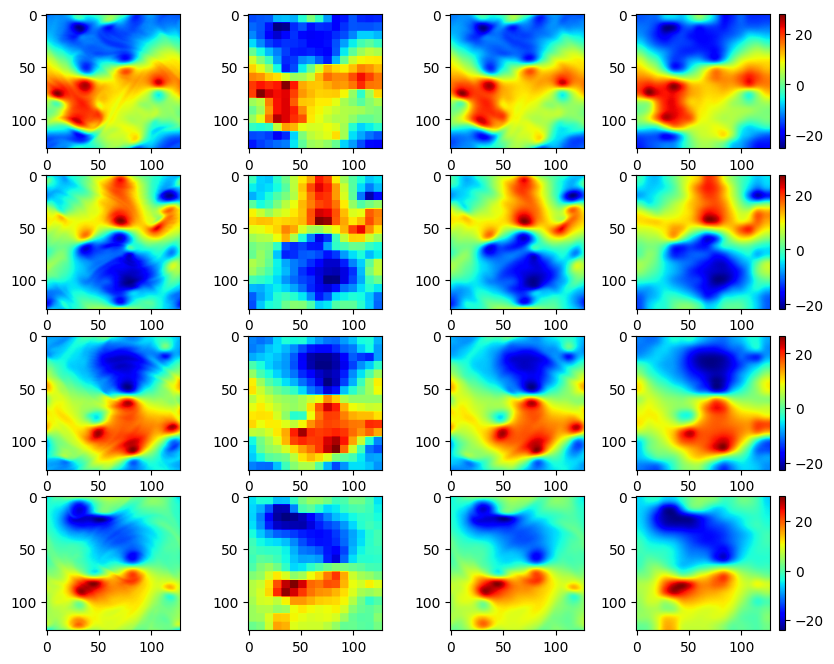

In [4]:
import matplotlib.pyplot as plt

x, y = next(iter(dataloaders["test"]))
ox, oy = torch.clone(x), torch.clone(y)
x, y = x.to(device), y.to(device)

rows, cols = 4, 4
vmin, vmax = -42, +42
print(torch.min(y).item(), torch.max(y).item())
cmap = 'jet'
#cmap = 'RdBu'

figure = plt.figure(figsize=(10, 8))
pred = model(x)
for i in range(rows):
    figure.add_subplot(rows, cols, i*cols+1)
    plt.imshow(oy[i,0].numpy().transpose(), interpolation=None, cmap=cmap)
    figure.add_subplot(rows, cols, i*cols+2)
    plt.imshow(ox[i,0].numpy().transpose(), interpolation=None, cmap=cmap)
    figure.add_subplot(rows, cols, i*cols+3)
    plt.imshow(pred[i,0].cpu().detach().numpy().squeeze().transpose(), interpolation=None, cmap=cmap)
    figure.add_subplot(rows, cols, i*cols+4)
    downscaled_img = torch.nn.AvgPool2d(128//resolution)(ox[i])
    bicubic_scaled_img = Resize(128, InterpolationMode.BICUBIC, antialias=True)(downscaled_img)
    plt.imshow(bicubic_scaled_img[0].numpy().squeeze().transpose(), interpolation=None, cmap=cmap)
    plt.colorbar()
print("Pred NER:   ", NER(pred[4], y[4]).item())
print("Direct NER: ", NER(ox[4], oy[4]).item())
print("Bicubic NER:", NER(bicubic_scaled_img, oy[4]).item())

### Testing area

In [50]:
model = CompactC4(4, 1, 3)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Name: {name}, Parameters: {param.data.numel()}")

#parameter = 6*N*channel² reg2reg

# Parameter changes for different kernel sizes: (N=4, C=1, vec2reg)
# 1x1   3x3    5x5    7x7    9x9
# 2     12     22     36     62
#   +10    +10    +14    +26

Name: block.0.bias, Parameters: 1
Name: block.0.weights, Parameters: 12
Name: block.2.bias, Parameters: 1
Name: block.2.weights, Parameters: 24
Name: block.4.weights, Parameters: 12


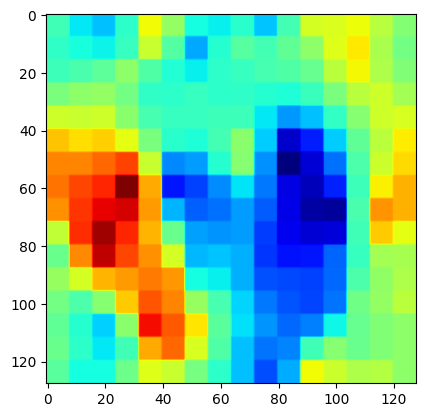

In [60]:
r2_act = gspaces.flipRot2dOnR2(N=4)
fiberelements = r2_act.fibergroup.elements
#generator=get_torch_generator(42)
r = torch.randint(len(fiberelements), (1,), generator=generator)
g = r2_act.fibergroup.elements[r]

feat_type = enn.FieldType(r2_act, [r2_act.irrep(1, 1)])
x, y = next(iter(dataloaders["test"]))
lr, hr = x[0], y[0]
lr, hr = feat_type(lr.unsqueeze(0)), feat_type(hr.unsqueeze(0))
lr, hr = lr.transform(g), hr.transform(g)
lr, hr = lr.tensor.squeeze(), hr.tensor.squeeze()
plt.imshow(lr[0], cmap='jet')

tensor([0, 0, 0,  ..., 0, 0, 0], dtype=torch.uint8)


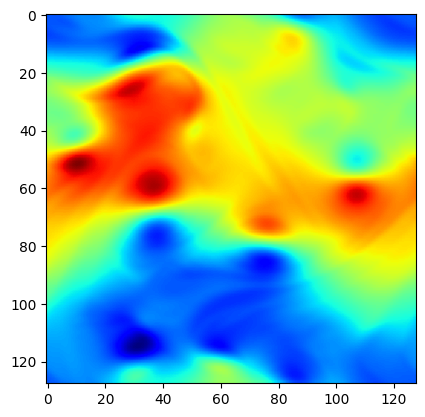

In [88]:
import matplotlib.pyplot as plt

#dataloaders = create_dataloaders(data_dir, batch_size, resolution, 0, interpolation, 3500)

print(dataloaders["test"].dataset.generator.get_state())
x, y = next(iter(dataloaders["test"]))
plt.imshow(y[0, 0].numpy().transpose(), cmap='jet')

1.3275001049041748
1.3395652770996094


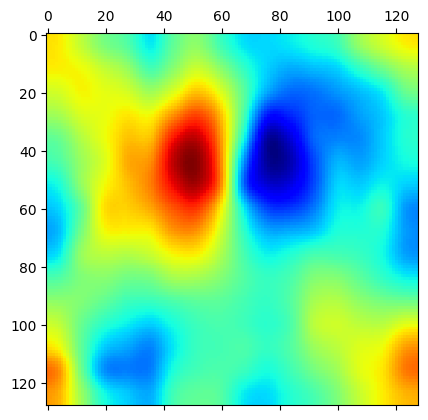

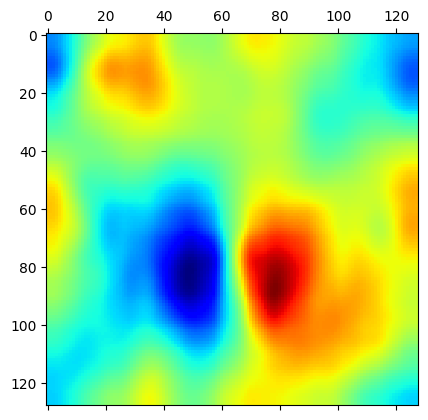

In [94]:
from glob import glob
from torchvision.transforms import InterpolationMode, RandomCrop, Resize
import matplotlib.pyplot as plt

data_dir = "/home/hubble/data/decaying_turbulence/velocity/train"

dataset = OriginalVelocityDataset(data_dir, resolution=16, interpolation=InterpolationMode.BICUBIC)
lr1, hr1 = dataset.__getitem__(0)
plt.matshow(lr1[0], cmap='jet')

dataset = VelocityDataset(data_dir, resolution=16, interpolation="bicubic", data_augmentation_group="D4")
lr2, hr2 = dataset.__getitem__(0)
plt.matshow(lr2[0], cmap='jet')

print(NER(lr1, lr2).item())
print(NER(hr1, hr2).item())

In [107]:
x, y = next(iter(dataloaders["test"]))

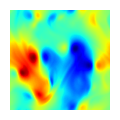

In [127]:
import matplotlib.pyplot as plt

fig = plt.figure(frameon=False)
fig.set_size_inches(1, 1)

ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)

ax.imshow(y[0, 1].numpy().transpose(), cmap='jet', aspect='auto')
fig.savefig("hr1", dpi=128)